In [1]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import shap
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load the data dictionary
data_dictionary = pd.read_csv('Data/train_data_dictionary.csv')

# Display the data dictionary
data_dictionary

,Column,Description
0,case_id,Case_ID registered in Hospital
1,Hospital_code,Unique code for the Hospital
2,Hospital_type_code,Unique code for the type of Hospital
3,City_Code_Hospital,City Code of the Hospital
4,Hospital_region_code,Region Code of the Hospital
5,Available Extra Rooms in Hospital,Number of Extra rooms available in the Hospital
6,Department,Department overlooking the case
7,Ward_Type,Code for the Ward type
8,Ward_Facility_Code,Code for the Ward Facility
9,Bed Grade,Condition of Bed in the Ward


In [3]:
# Load the training data
train_data = pd.read_csv('Data/train_data.csv')

# Display the first few rows of the training data
train_data.head()


,case_id,Hospital_code,Hospital_type_code,City_Code_Hospital,Hospital_region_code,Available Extra Rooms in Hospital,Department,Ward_Type,Ward_Facility_Code,Bed Grade,patientid,City_Code_Patient,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit,Stay
0,1,8,c,3,Z,3,radiotherapy,R,F,2.0,31397,7.0,Emergency,Extreme,2,51-60,4911.0,0-10
1,2,2,c,5,Z,2,radiotherapy,S,F,2.0,31397,7.0,Trauma,Extreme,2,51-60,5954.0,41-50
2,3,10,e,1,X,2,anesthesia,S,E,2.0,31397,7.0,Trauma,Extreme,2,51-60,4745.0,31-40
3,4,26,b,2,Y,2,radiotherapy,R,D,2.0,31397,7.0,Trauma,Extreme,2,51-60,7272.0,41-50
4,5,26,b,2,Y,2,radiotherapy,S,D,2.0,31397,7.0,Trauma,Extreme,2,51-60,5558.0,41-50


In [4]:
# Check for missing values
missing_values = train_data.isnull().sum()

# Descriptive statistics for numerical features
numerical_summary = train_data.describe()

missing_values, numerical_summary


(case_id                                 0
 Hospital_code                           0
 Hospital_type_code                      0
 City_Code_Hospital                      0
 Hospital_region_code                    0
 Available Extra Rooms in Hospital       0
 Department                              0
 Ward_Type                               0
 Ward_Facility_Code                      0
 Bed Grade                             113
 patientid                               0
 City_Code_Patient                    4532
 Type of Admission                       0
 Severity of Illness                     0
 Visitors with Patient                   0
 Age                                     0
 Admission_Deposit                       0
 Stay                                    0
 dtype: int64,
              case_id  Hospital_code  City_Code_Hospital  \
 count  318438.000000  318438.000000       318438.000000   
 mean   159219.500000      18.318841            4.771717   
 std     91925.276848       8.6

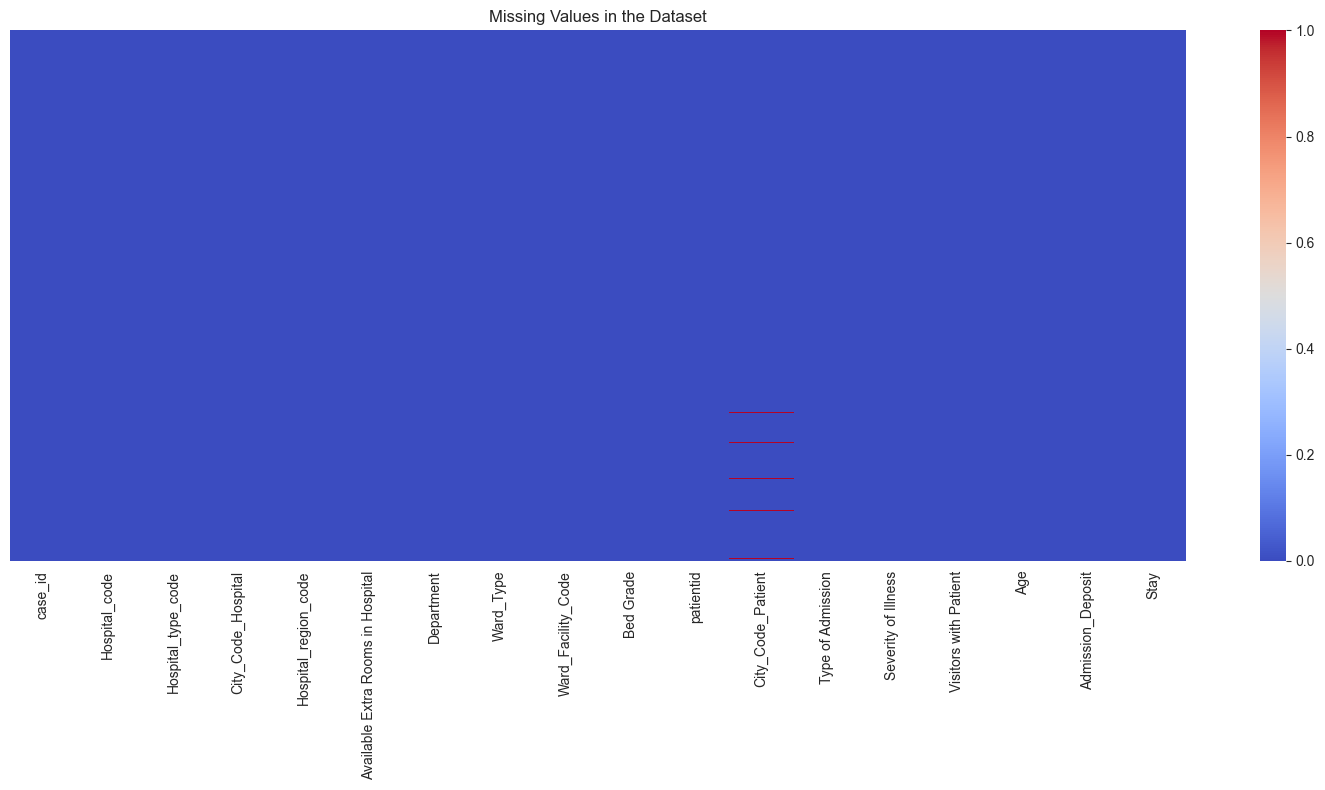

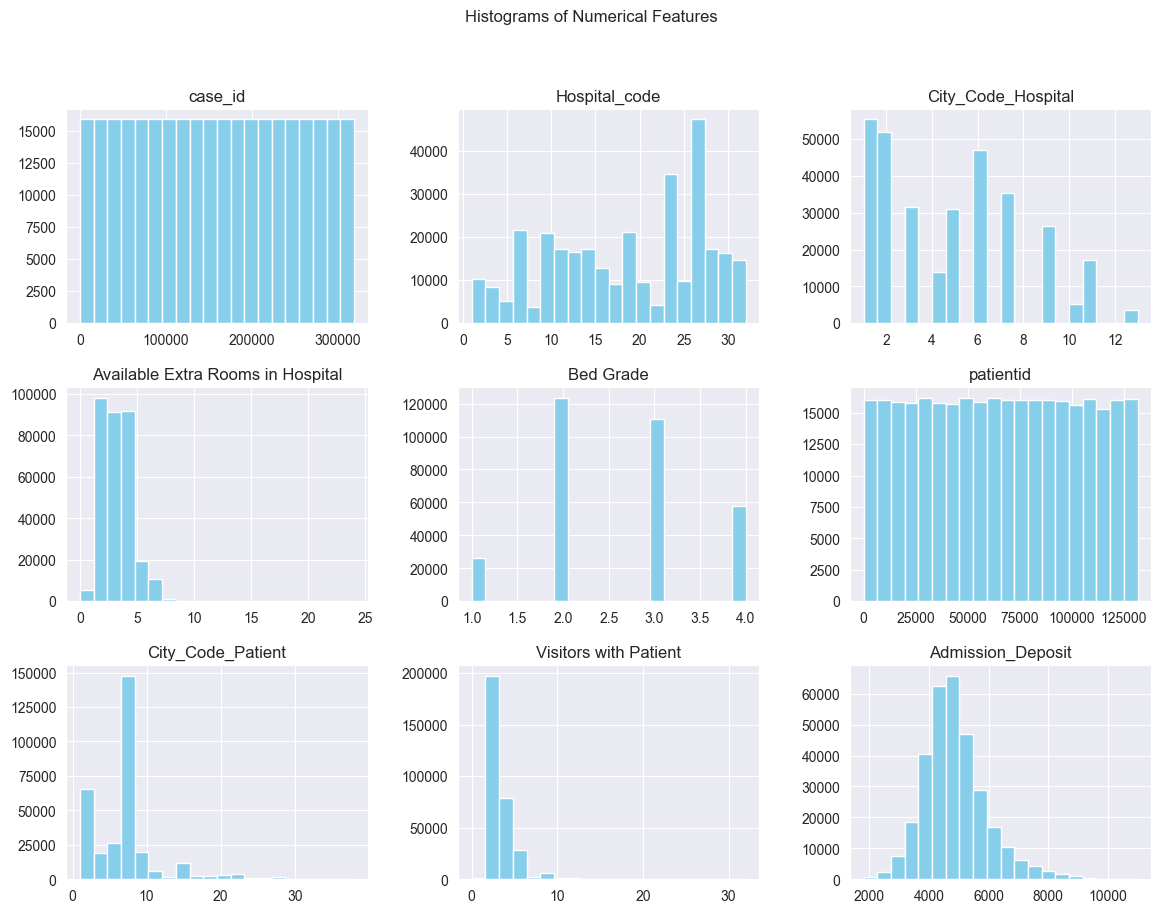

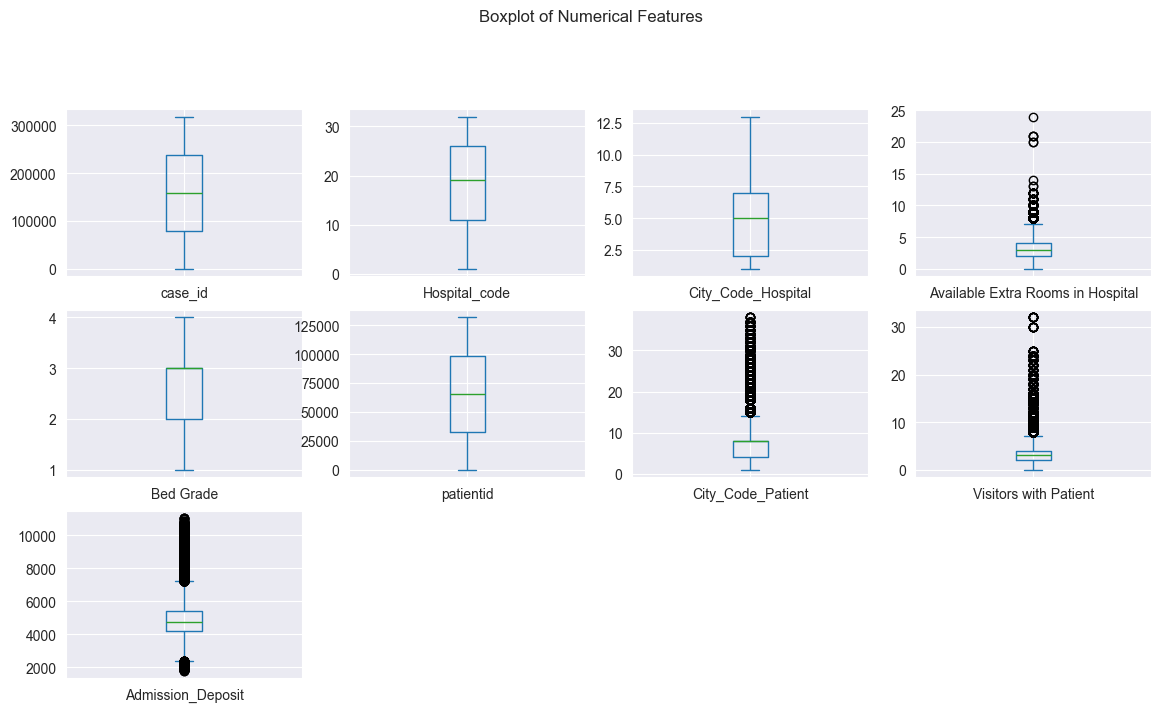

In [5]:
# Visualize missing values
plt.figure(figsize=(15, 8)) 
sns.heatmap(train_data.isnull(), cbar=True, yticklabels=False, cmap='coolwarm') 
plt.title('Missing Values in the Dataset')
plt.xticks(rotation=90, ha='center')  
plt.tight_layout() 
plt.show()

# Histograms for numerical features
train_data.hist(bins=20, figsize=(14,10), color='skyblue')
plt.suptitle('Histograms of Numerical Features')
plt.show()

# Boxplot for numerical features to check for outliers
num_features = train_data.select_dtypes(include=['float64', 'int64']).columns
train_data[num_features].plot(kind='box', subplots=True, layout=(4,4), figsize=(14,10), title="Boxplot of Numerical Features")
plt.show()


In [6]:
# List of categorical variables including the target variable
categorical_vars = ['Hospital_type_code', 'Hospital_region_code', 'Department', 'Ward_Type', 
                    'Ward_Facility_Code', 'Bed Grade', 'Type of Admission', 'Severity of Illness', 
                    'Age', 'Stay']

# Frequency distribution of categorical variables
categorical_distributions = {var: train_data[var].value_counts(normalize=True) for var in categorical_vars}

categorical_distributions


{'Hospital_type_code': Hospital_type_code
 a    0.450402
 b    0.216513
 c    0.144229
 e    0.077786
 d    0.064028
 f    0.033611
 g    0.013431
 Name: proportion, dtype: float64,
 'Hospital_region_code': Hospital_region_code
 X    0.418719
 Y    0.384464
 Z    0.196817
 Name: proportion, dtype: float64,
 'Department': Department
 gynecology            0.783468
 anesthesia            0.093108
 radiotherapy          0.089550
 TB & Chest disease    0.030103
 surgery               0.003772
 Name: proportion, dtype: float64,
 'Ward_Type': Ward_Type
 R    0.401796
 Q    0.333393
 S    0.244299
 P    0.015846
 T    0.004638
 U    0.000028
 Name: proportion, dtype: float64,
 'Ward_Facility_Code': Ward_Facility_Code
 F    0.354081
 E    0.173820
 D    0.162697
 C    0.111365
 B    0.110401
 A    0.087634
 Name: proportion, dtype: float64,
 'Bed Grade': Bed Grade
 2.0    0.388505
 3.0    0.347390
 4.0    0.180840
 1.0    0.083264
 Name: proportion, dtype: float64,
 'Type of Admission': Type o

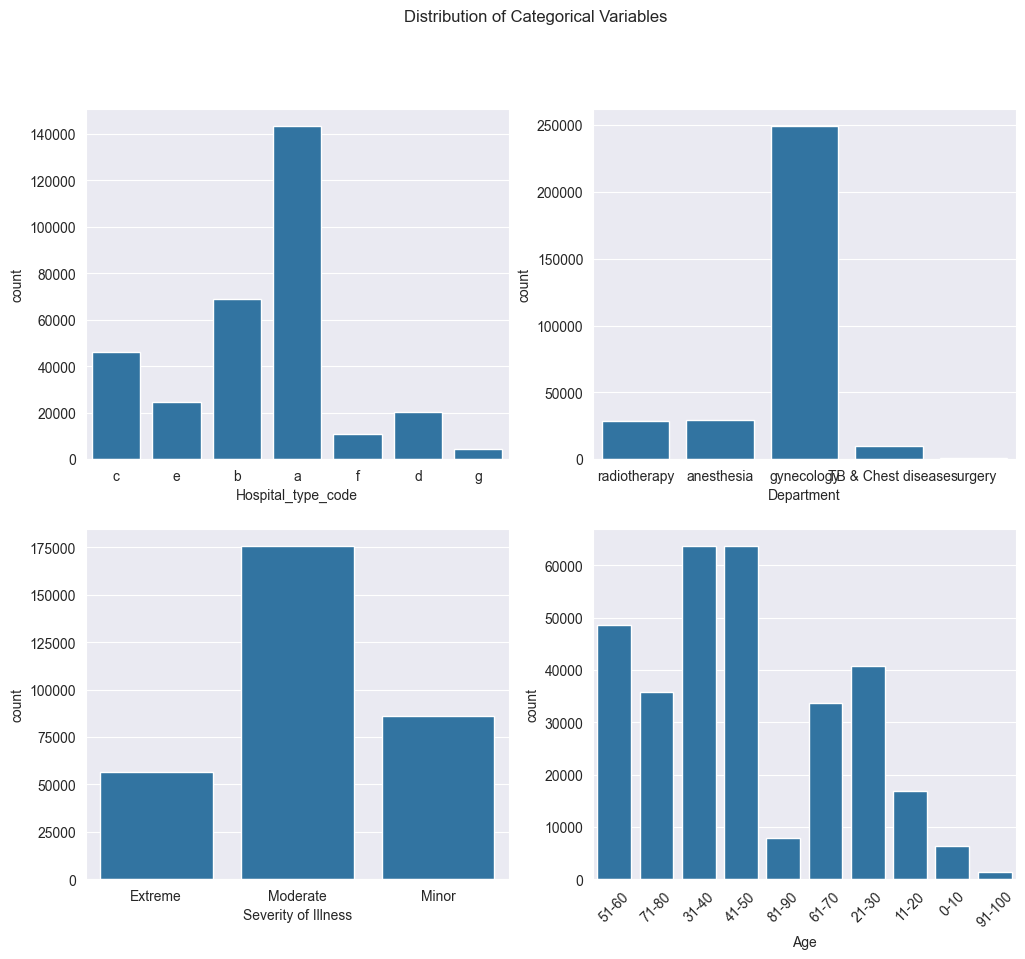

In [7]:
# Visualize the distribution of a few categorical variables
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
sns.countplot(x='Hospital_type_code', data=train_data, ax=axes[0, 0])
sns.countplot(x='Department', data=train_data, ax=axes[0, 1])
sns.countplot(x='Severity of Illness', data=train_data, ax=axes[1, 0])
sns.countplot(x='Age', data=train_data, ax=axes[1, 1])
plt.xticks(rotation=45)
plt.suptitle('Distribution of Categorical Variables')
plt.show()


In [8]:
# Impute missing values with the mode
train_data['Bed Grade'].fillna(train_data['Bed Grade'].mode()[0], inplace=True)
train_data['City_Code_Patient'].fillna(train_data['City_Code_Patient'].mode()[0], inplace=True)

# Verify if missing values have been imputed
missing_values_after_imputation = train_data.isnull().sum()

missing_values_after_imputation


case_id                              0
Hospital_code                        0
Hospital_type_code                   0
City_Code_Hospital                   0
Hospital_region_code                 0
Available Extra Rooms in Hospital    0
Department                           0
Ward_Type                            0
Ward_Facility_Code                   0
Bed Grade                            0
patientid                            0
City_Code_Patient                    0
Type of Admission                    0
Severity of Illness                  0
Visitors with Patient                0
Age                                  0
Admission_Deposit                    0
Stay                                 0
dtype: int64

In [9]:
# Selecting categorical variables for one-hot encoding
categorical_vars_for_encoding = ['Hospital_type_code', 'Hospital_region_code', 'Department', 
                                 'Ward_Type', 'Ward_Facility_Code', 'Bed Grade', 'Type of Admission', 
                                 'Severity of Illness', 'Age']

# Applying OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)

# Select only the specified categorical columns for encoding
categorical_data = train_data[categorical_vars_for_encoding]

# Apply the encoder
encoded_features = encoder.fit_transform(categorical_data)

# Check the shape of the encoded features
print("Encoded features shape:", encoded_features.shape)

# Create a DataFrame with the encoded features, using generated feature names
encoded_features_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out())

# Display the shape of the DataFrame to confirm it matches expectations
print("DataFrame shape:", encoded_features_df.shape)

# Drop the original categorical columns from the training data
train_data_encoded = train_data.drop(columns=categorical_vars_for_encoding)

# Concatenate the encoded features with the rest of the training data
train_data_final = pd.concat([train_data_encoded, encoded_features_df], axis=1)

# Display the first few rows to verify
print(train_data_final.head())


Encoded features shape: (318438, 47)
DataFrame shape: (318438, 47)
   case_id  Hospital_code  City_Code_Hospital  \
0        1              8                   3   
1        2              2                   5   
2        3             10                   1   
3        4             26                   2   
4        5             26                   2   

   Available Extra Rooms in Hospital  patientid  City_Code_Patient  \
0                                  3      31397                7.0   
1                                  2      31397                7.0   
2                                  2      31397                7.0   
3                                  2      31397                7.0   
4                                  2      31397                7.0   

   Visitors with Patient  Admission_Deposit   Stay  Hospital_type_code_a  ...  \
0                      2             4911.0   0-10                   0.0  ...   
1                      2             5954.0  41-50     

In [10]:
# Separating the features and the target variable
X = train_data_encoded.drop('Stay', axis=1)
y = train_data_encoded['Stay']

# Splitting the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Verifying the size of the splits
X_train.shape, X_val.shape, y_train.shape, y_val.shape

# Initialize the Gradient Boosting Classifier
gbm = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

# Train the model
gbm.fit(X_train, y_train)

# Make predictions on the validation set
y_pred = gbm.predict(X_val)

# Evaluate the model
accuracy = accuracy_score(y_val, y_pred)
conf_matrix = confusion_matrix(y_val, y_pred)
report = classification_report(y_val, y_pred)

print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(report)

Accuracy: 0.36897060670770004
Confusion Matrix:
[[  362  1876  2292   132     0    58     1     0     0     0     0]
 [  232  5006  8851   763     1   768     5     0     0     0     2]
 [  235  3517 12659   561     5   464     5     0    21     2    29]
 [  151  1518  5235  1431     1  2638     1     2     8     1    46]
 [   74   294  1602   142     5   204     0     0     4     5    19]
 [   71   623  1493  1178     0  3426     2     5    68     3   135]
 [   18    68   298    46     0    94     3     1     4     1    16]
 [   18   127   351   276     1  1094     0     1    15     3   165]
 [    8    26    66    44     0   624     0     2   105     0    92]
 [    7    25    91    70     1   286     0     1     3     4    65]
 [   20    50   100    66     0   542     0     3    51     7   497]]
Classification Report:
                    precision    recall  f1-score   support

              0-10       0.30      0.08      0.12      4721
             11-20       0.38      0.32      0.3

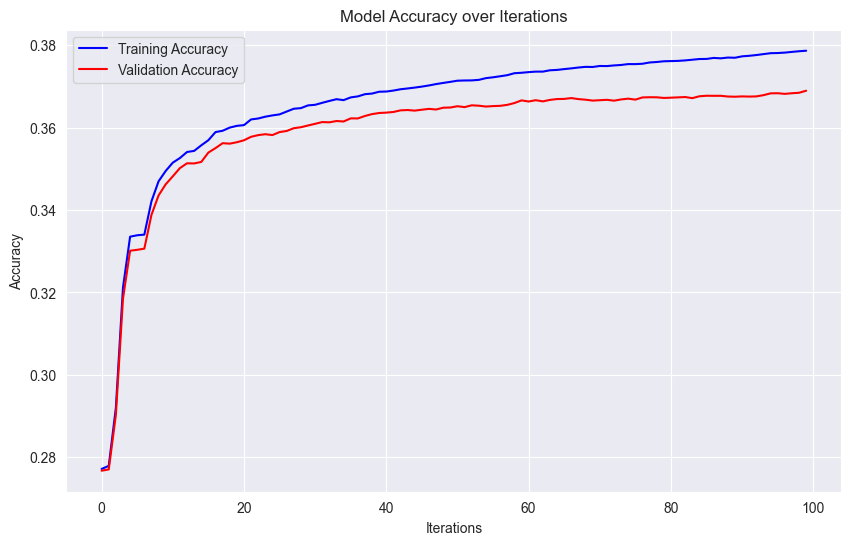

In [11]:
from sklearn.metrics import accuracy_score

# Initialize lists to store accuracies
train_accuracies = []
val_accuracies = []

# Calculate accuracy at each stage
for y_train_pred in gbm.staged_predict(X_train):
    train_accuracies.append(accuracy_score(y_train, y_train_pred))

for y_val_pred in gbm.staged_predict(X_val):
    val_accuracies.append(accuracy_score(y_val, y_val_pred))

# Plotting accuracies
plt.figure(figsize=(10, 6))
plt.plot(train_accuracies, label='Training Accuracy', color='blue')
plt.plot(val_accuracies, label='Validation Accuracy', color='red')
plt.title('Model Accuracy over Iterations')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

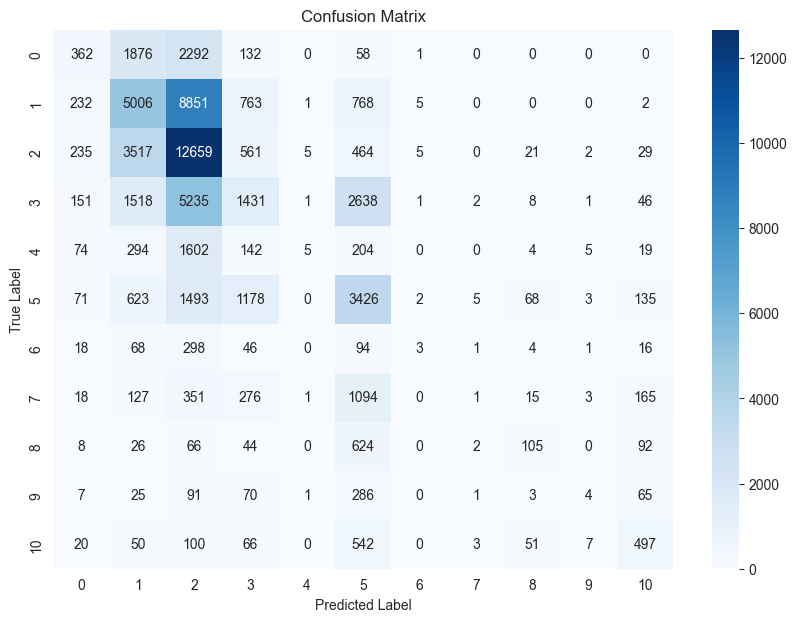

In [12]:
# Confusion Matrix Visualization
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
